# Preprocessing

### Preperation
Import libraries and create the pandas dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

energy_df = pd.read_csv('data/energy_dataset.csv')
energy_df['time'] = pd.to_datetime(energy_df['time'])
columns = energy_df.columns

### Remove empty columns

In [2]:
energy_df = energy_df.loc[:, (energy_df.fillna(0) != 0).any(axis=0)]

### Fill in missing datapoints

In [3]:
energy_df = energy_df.interpolate(method='linear')

### Outlier detection

In [4]:
column_names = energy_df.columns
window_percentage = 3

# Function to get the upper and lower bands
def get_bands(data):
        upper_band = np.mean(data) + (3 * np.std(data))
        lower_band = np.mean(data) - (3 * np.std(data))
        return upper_band, lower_band

anomaly_masks = {}
for column_name in column_names[1:]:
    column = energy_df[column_name]
    N = len(column)
    k = int(N * (window_percentage/2/100))

    # Calculate the bands for each data point
    bands = [get_bands(column[max(0, i-k):min(i+k, N)]) for i in range(N)]
    upper, lower = zip(*bands)

    # Identify the anomalies
    anomalies = (column > upper) | (column < lower)
    anomaly_masks[column_name] = anomalies

# Combine anomaly masks using bitwise OR (|) for each column's mask
combined_mask = np.column_stack(list(anomaly_masks.values())).any(axis=1)

# Filter the data
filtered_data = energy_df[~combined_mask]



### Plot data

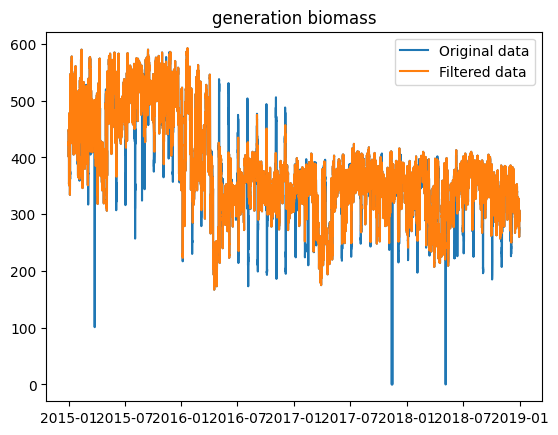

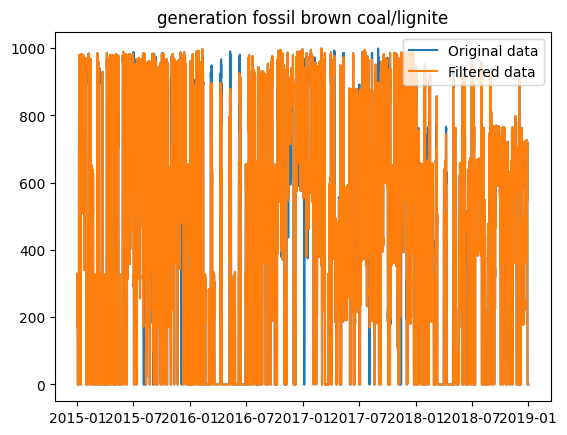

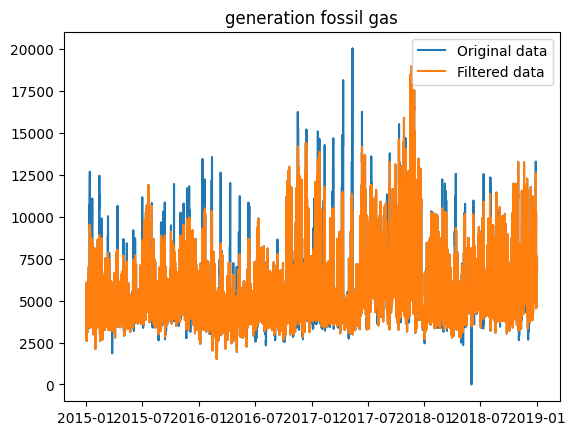

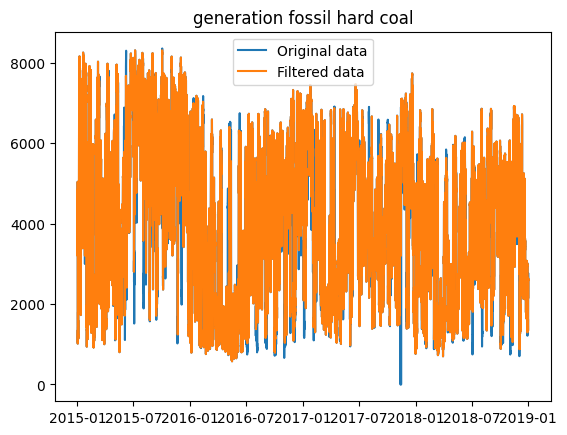

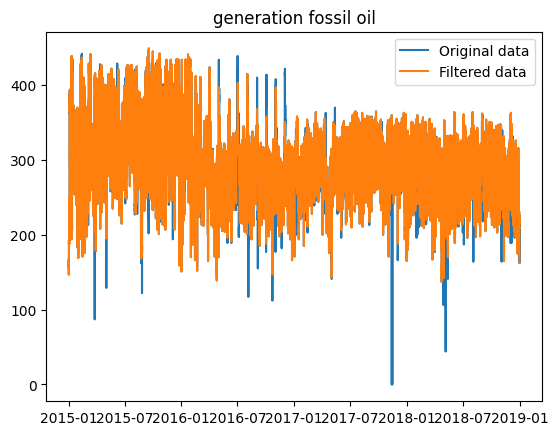

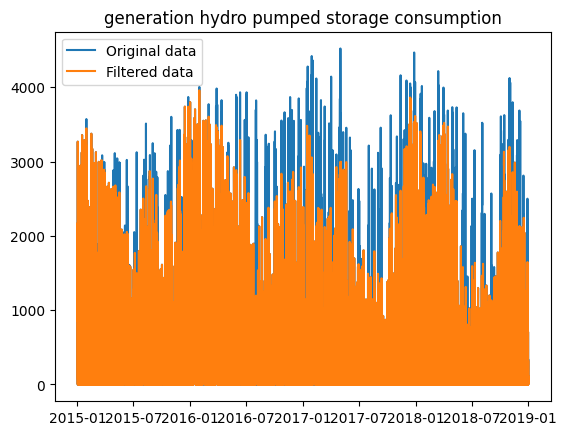

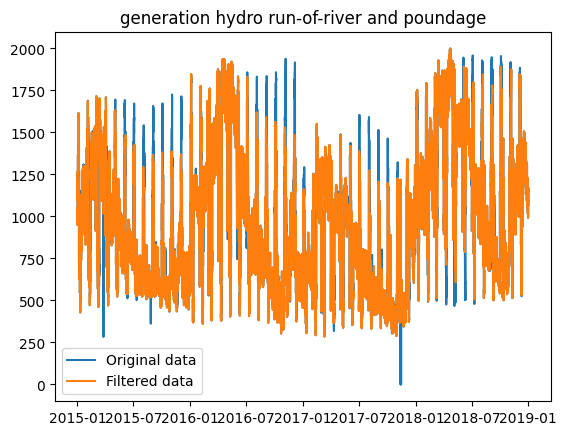

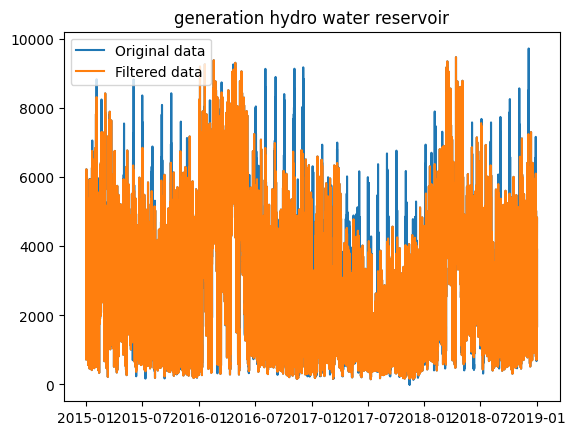

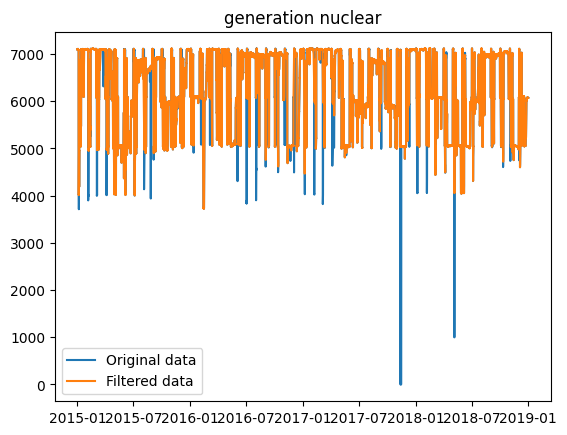

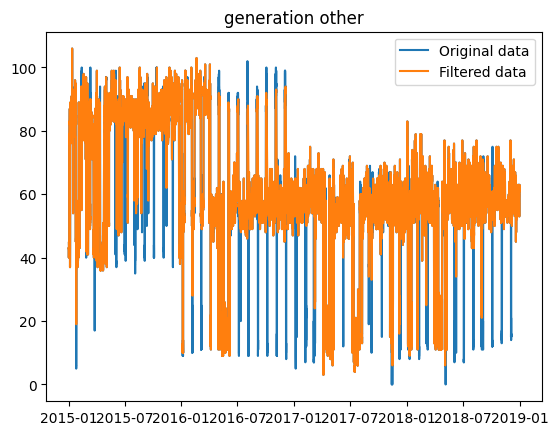

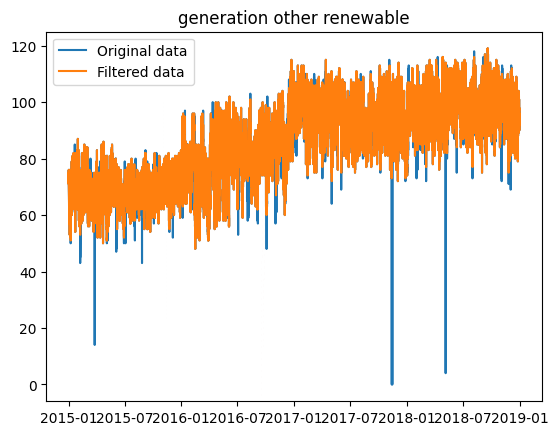

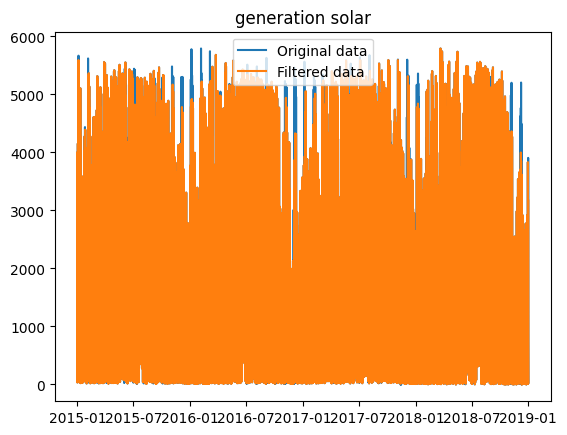

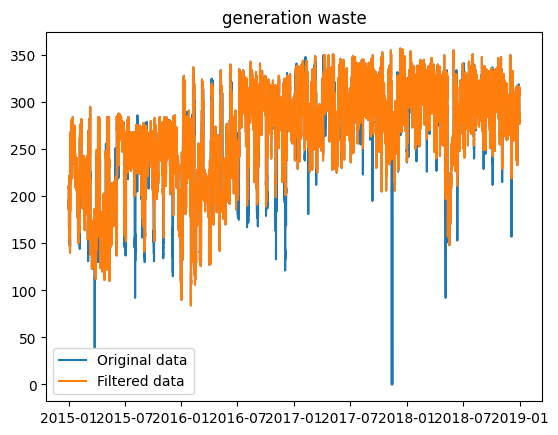

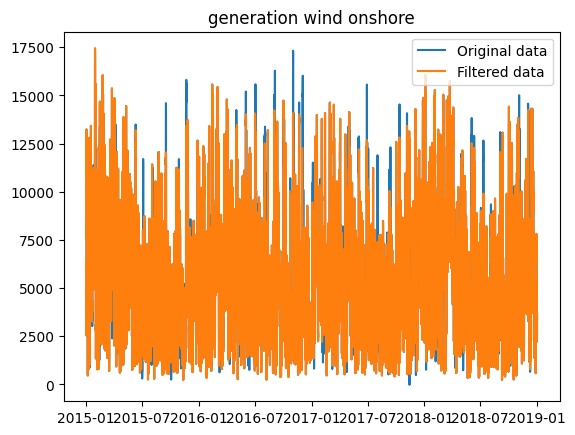

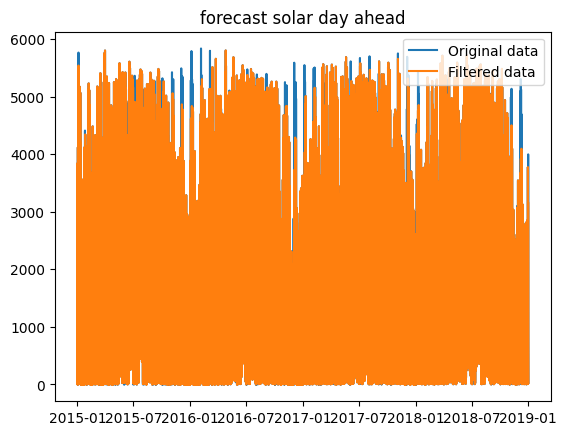

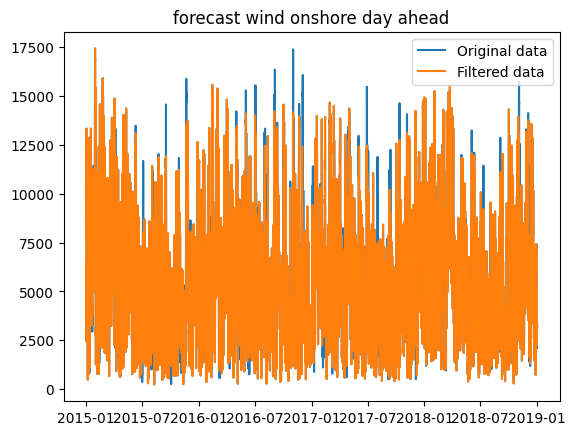

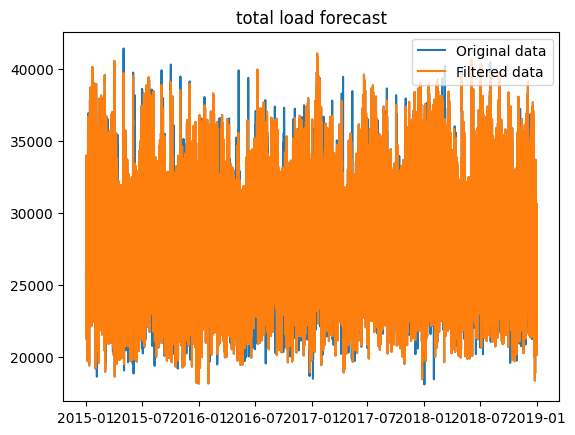

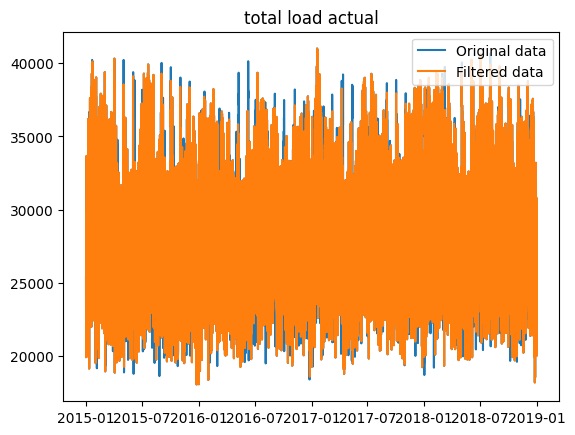

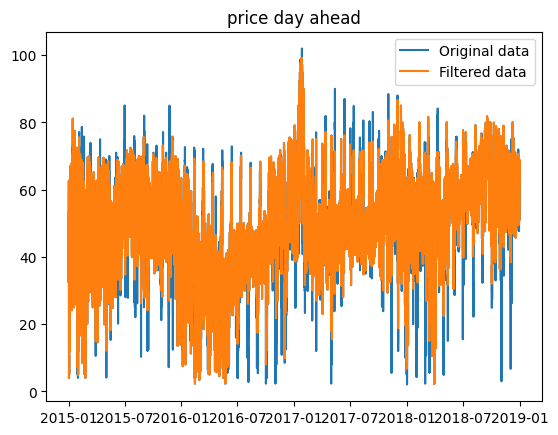

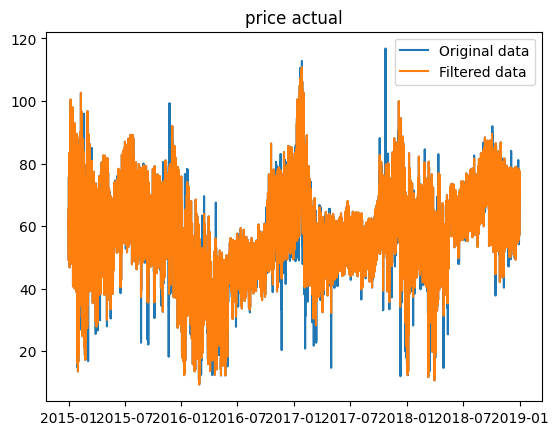

In [5]:
for column_name in column_names[1:]:
    plt.plot(energy_df['time'], energy_df[column_name], label='Original data')
    plt.plot(filtered_data['time'], filtered_data[column_name], label='Filtered data')
    plt.title(column_name)
    plt.legend()
    plt.show()